### Importing relevant libraries

In [1]:
from PIL import Image 
import numpy as np
import os
from os import listdir
from PIL import Image 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import regularizers
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### Loading labels

In [2]:
df= pd.read_csv('../input/arabic-hwr-ai-pro-intake1/train.csv')
df

,id,label
0,0,24
1,1,2
2,2,17
3,3,14
4,4,19
...,...,...
13435,13435,5
13436,13436,26
13437,13437,2
13438,13438,24


In [3]:
labels= df['label']

In [4]:
labels.shape

(13440,)

### Loading images

In [5]:
train_path="../input/arabic-hwr-ai-pro-intake1/train/"
test_path="../input/arabic-hwr-ai-pro-intake1/test/"

In [6]:
def loadImages(path):
    # returns array of images
    
    imagesList = listdir(path)
    imagesList.sort()
    image_df = []
    for image in imagesList:
        img = Image.open(path + image).convert('L')
        img=img.resize((32,32))
        img=np.asarray(img)
        img=img.reshape((32,32,1))
        img=img/255
        image_df.append(img)
    
    return np.array(image_df)

In [7]:
train_data = loadImages(train_path)
test_data= loadImages(test_path)

In [8]:
train_data.shape

(13440, 32, 32, 1)

In [9]:
test_data.shape

(3360, 32, 32, 1)

### Visualizing some images

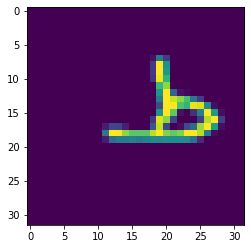

In [10]:
plt.imshow(train_data[3000])

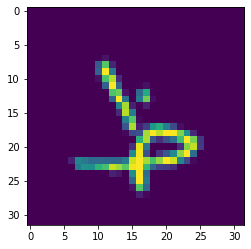

In [11]:
plt.imshow(train_data[2])

### Shuffling images

In [12]:
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)
shuffled_images = train_data[indices]
shuffled_labels = labels[indices]


### Dividing data into train/validation/test

In [13]:
validation_samples= int(0.1*train_data.shape[0])    #nearly 10%
test_samples = int(0.1*train_data.shape[0])        #nearly 10%    
train_samples = train_data.shape[0]-(validation_samples+test_samples)      #nearly 80%


In [14]:
validation_images= shuffled_images[:validation_samples]
validation_labels= shuffled_labels[:validation_samples]

test_images = shuffled_images[validation_samples:validation_samples+test_samples]
test_labels= shuffled_labels[validation_samples:validation_samples+test_samples]


train_images = shuffled_images[validation_samples+test_samples:]
train_labels = shuffled_labels[validation_samples+test_samples:]



In [15]:
train_images.shape

(10752, 32, 32, 1)

In [16]:
validation_images.shape

(1344, 32, 32, 1)

In [17]:
test_images.shape

(1344, 32, 32, 1)

### Model outline

In [18]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(64,3,activation='relu',input_shape=(32,32,1)),
    tf.keras.layers.Conv2D(64,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        
    tf.keras.layers.Conv2D(128,3,activation='relu'),
    tf.keras.layers.Conv2D(128,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024,'relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1024,'relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(29)
    
    
])                                

2021-10-24 21:29:53.034503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 21:29:53.125663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 21:29:53.126392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 21:29:53.128103: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Model architecture

In [19]:
model.summary(line_length=75)

Model: "sequential"
___________________________________________________________________________
Layer (type)                     Output Shape                  Param #     
conv2d (Conv2D)                  (None, 30, 30, 64)            640         
___________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 64)            36928       
___________________________________________________________________________
max_pooling2d (MaxPooling2D)     (None, 14, 14, 64)            0           
___________________________________________________________________________
conv2d_2 (Conv2D)                (None, 12, 12, 128)           73856       
___________________________________________________________________________
conv2d_3 (Conv2D)                (None, 10, 10, 128)           147584      
___________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 5, 5, 128)             0    

### Compiling our model

In [20]:
loss_fn= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [21]:
model.compile(optimizer='adam',loss=loss_fn,metrics=['accuracy'])

### Defining early stopping technique

In [22]:
early_stopping=tf.keras.callbacks.EarlyStopping(
monitor='val_loss',
mode='auto',
min_delta=0,
patience=5,
verbose=0,
restore_best_weights=True)

### Fitting our model

In [23]:
model.fit(
    train_images,
    train_labels,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    validation_data= (validation_images,validation_labels),
    verbose=2
)

2021-10-24 21:29:56.104660: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-10-24 21:29:57.441605: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


168/168 - 8s - loss: 3.2001 - accuracy: 0.0680 - val_loss: 2.5062 - val_accuracy: 0.2254
Epoch 2/100
168/168 - 1s - loss: 2.0465 - accuracy: 0.3227 - val_loss: 1.1437 - val_accuracy: 0.6280
Epoch 3/100
168/168 - 1s - loss: 1.2744 - accuracy: 0.5438 - val_loss: 0.7663 - val_accuracy: 0.7381
Epoch 4/100
168/168 - 1s - loss: 0.9131 - accuracy: 0.6698 - val_loss: 0.5470 - val_accuracy: 0.8140
Epoch 5/100
168/168 - 1s - loss: 0.6631 - accuracy: 0.7614 - val_loss: 0.3476 - val_accuracy: 0.8817
Epoch 6/100
168/168 - 1s - loss: 0.5102 - accuracy: 0.8280 - val_loss: 0.3103 - val_accuracy: 0.9018
Epoch 7/100
168/168 - 1s - loss: 0.3961 - accuracy: 0.8691 - val_loss: 0.2424 - val_accuracy: 0.9167
Epoch 8/100
168/168 - 1s - loss: 0.3488 - accuracy: 0.8852 - val_loss: 0.2148 - val_accuracy: 0.9249
Epoch 9/100
168/168 - 1s - loss: 0.2894 - accuracy: 0.9072 - val_loss: 0.1812 - val_accuracy: 0.9539
Epoch 10/100
168/168 - 1s - loss: 0.2322 - accuracy: 0.9252 - val_loss: 0.1802 - val_accuracy: 0.9487
E

In [24]:
model.evaluate(test_images,test_labels)

42/42 [==============================] - 0s 3ms/step - loss: 0.1493 - accuracy: 0.9650


[0.1492651253938675, 0.965029776096344]

### Retraining the model with larger batch size

In [25]:
model.fit(
    train_images,
    train_labels,
    epochs=10,
    batch_size=512,
    callbacks=[early_stopping],
    validation_data= (validation_images,validation_labels),
    verbose=2
)

Epoch 1/10
21/21 - 2s - loss: 0.0869 - accuracy: 0.9731 - val_loss: 0.1582 - val_accuracy: 0.9621
Epoch 2/10
21/21 - 1s - loss: 0.0699 - accuracy: 0.9781 - val_loss: 0.1564 - val_accuracy: 0.9643
Epoch 3/10
21/21 - 1s - loss: 0.0533 - accuracy: 0.9825 - val_loss: 0.1567 - val_accuracy: 0.9680
Epoch 4/10
21/21 - 1s - loss: 0.0554 - accuracy: 0.9831 - val_loss: 0.1579 - val_accuracy: 0.9650
Epoch 5/10
21/21 - 1s - loss: 0.0512 - accuracy: 0.9837 - val_loss: 0.1572 - val_accuracy: 0.9688
Epoch 6/10
21/21 - 1s - loss: 0.0508 - accuracy: 0.9829 - val_loss: 0.1507 - val_accuracy: 0.9673
Epoch 7/10
21/21 - 1s - loss: 0.0448 - accuracy: 0.9860 - val_loss: 0.1624 - val_accuracy: 0.9658
Epoch 8/10
21/21 - 1s - loss: 0.0441 - accuracy: 0.9853 - val_loss: 0.1509 - val_accuracy: 0.9702
Epoch 9/10
21/21 - 1s - loss: 0.0411 - accuracy: 0.9874 - val_loss: 0.1592 - val_accuracy: 0.9673
Epoch 10/10
21/21 - 1s - loss: 0.0381 - accuracy: 0.9880 - val_loss: 0.1654 - val_accuracy: 0.9688


In [26]:
model.evaluate(test_images,test_labels)

42/42 [==============================] - 0s 3ms/step - loss: 0.1569 - accuracy: 0.9710


[0.1568971872329712, 0.9709821343421936]

### Generating predictions

In [27]:
predictions= model.predict(test_data)

In [28]:
predictions

array([[-56.221394  , -38.2534    , -44.943253  , ...,  34.926395  ,
          0.40493226, -22.833252  ],
       [-17.884071  ,  -3.8064103 ,  -2.6648774 , ..., -12.656643  ,
         -2.6376905 ,  -7.740626  ],
       [-48.33496   ,  33.52644   , -11.56693   , ..., -26.79501   ,
        -19.787048  , -26.404879  ],
       ...,
       [-28.620642  , -19.829472  ,  -8.603633  , ..., -26.79694   ,
        -24.993547  , -15.572935  ],
       [-24.831638  ,  -0.5212949 , -14.013842  , ..., -21.459522  ,
         -8.107895  , -18.875954  ],
       [-14.001586  , -11.5988035 ,  -9.730214  , ...,  -9.848003  ,
         -8.35116   ,  -6.0066113 ]], dtype=float32)

In [29]:
predictions= np.argmax(predictions,axis=1)

In [30]:
predictions.shape

(3360,)

In [31]:
test_df= pd.read_csv('../input/arabic-hwr-ai-pro-intake1/test.csv')

In [32]:
test_df

,id
0,0
1,1
2,2
3,3
4,4
...,...
3355,3355
3356,3356
3357,3357
3358,3358


In [33]:
preds= pd.DataFrame()
preds['id']= test_df['id']
preds['label']= predictions

### Exporting to csv

In [34]:
preds.to_csv('submission.csv',index=False)